## R1 To R1 Attractor, Position Around Point

In [1]:
using PBDS, StaticArrays, LinearAlgebra, BenchmarkTools

┌ Info: Precompiling PBDS [5f01a6e0-657c-4950-bc4f-54ae38a49d4c]
└ @ Base loading.jl:1278


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-15969971567897405035\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-12882591409443124964\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-15969971567897405035\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

## Setup

In [2]:
PBDS.metric_chart(xn, task::Attractor{<:PositionAroundPoint{R1,R1,S}}, CN::Chart{1,R1}) where S = 
    default_metric(xn, task, CN)
PBDS.potential_chart(xn, task::Attractor{<:PositionAroundPoint{R1,R1,S}}, CN::Chart{1,R1}) where S = sum(xn.^2)
PBDS.dissipative_forces_chart(xn, vn, task::Attractor{<:PositionAroundPoint{R1,R1,S}}, CN::Chart{1,R1}) where S = -3*vn
PBDS.weight_metric_chart(xn, vn, task::Attractor{<:PositionAroundPoint{R1,R1,S}}, CN::Chart{1,R1}) where S = default_weight_metric(xn, vn, task, CN)

In [3]:
xm_goal = SA[0.]
M, N = R1, R1
task = Attractor(PositionAroundPoint{M,N}(xm_goal))
CM, CN = Chart{1,M}(), Chart{1,N}()

(Chart{1,ℝ{1}}(), Chart{1,ℝ{1}}())

## Point Acceleration

In [4]:
# Initial state
xm = SA[2.]
vm = SA[2.]

σxddot, = single_task_acceleration(xm, vm, task, CM, CN)

([-10.0], Chart{1,ℝ{1}}())

## Single Trajectory

In [5]:
Time = 10
dt = 0.05
robot_coord_rep = ChartRep()
traj = propagate_task(xm, vm, task, CM, CN, Time, dt, robot_coord_rep)
traj.xm[end]

1-element SArray{Tuple{1},Float64,1,1} with indices SOneTo(1):
 0.0002863568464694686

In [6]:
using ProgressMeter, VectorizedRoutines
using Plots, Makie, Observables

┌ Info: Precompiling VectorizedRoutines [0e69188a-a5d4-5622-b4e4-a72373136fc5]
└ @ Base loading.jl:1278
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling Makie [ee78f7c6-11fb-53f2-987a-cfe4a2b5a57a]
└ @ Base loading.jl:1278


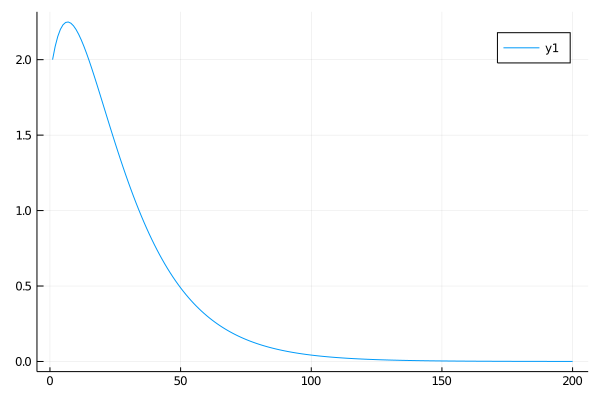

In [7]:
Nplot = length(traj.xm)
Plots.plot(getindex.(traj.xm,1)[1:Nplot])

## Multiple Trajectories

In [8]:
Time = 5
dt = 0.02
a = 2.
xm, vm = Matlab.meshgrid(-a:1.:a, -a:1.:a)
xm, vm = reshape(xm, length(xm)), reshape(vm, length(vm))

# Remove zero point
ind_mid = length(xm) ÷ 2 + 1 
deleteat!(xm, ind_mid)
deleteat!(vm, ind_mid)

ntraj = length(xm)
trajs = Array{Any}(undef, ntraj)
p = Progress(ntraj)

Threads.@threads for i = 1:ntraj
    trajs[i] = propagate_task(SA[xm[i]], SA[vm[i]], task, CM, CN, Time, dt, robot_coord_rep)
    next!(p)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


### In (x, v, a) space

In [9]:
AbstractPlotting.inline!(false)
fx(i) = [trajs[j].xm[i][1] for j = 1:ntraj]
fy(i) = [trajs[j].vm[i][1] for j = 1:ntraj]
fz(i) = [trajs[j].am[i][1] for j = 1:ntraj]
f(i) = [trajs[j].xm[i] trajs[j].vm[i] trajs[j].am[i]]
iobs = Observable(1)

ax_size, plot_size = 5, 800
limits = FRect3D((-ax_size, -ax_size, -ax_size), (2*ax_size, 2*ax_size, 2*ax_size))
scene = Scene(resolution = (plot_size, plot_size))
Makie.scatter!(scene, lift(i -> fx(i), iobs), lift(i -> fy(i), iobs), lift(i -> fz(i), iobs))
Makie.scatter!(scene, lift(i -> fx(i), iobs), lift(i -> fy(i), iobs), lift(i -> fz(i), iobs), markersize = ax_size/20, color = :blue, limits = limits)
Makie.scatter!(scene, [xm_goal[1] 0. 0.], markersize = ax_size/20, color = :darkgreen)
for i = 1:ntraj
    Makie.lines!(scene, getindex.(trajs[i].xm,1), getindex.(trajs[i].vm,1), getindex.(trajs[i].am,1), color = :purple, alpha = 0.1, transparency = true)
end

Makie.xlabel!(scene, "x")
Makie.ylabel!(scene, "v")
Makie.zlabel!(scene, "a")
axis = scene[Axis]
axis.showaxis = false
display(scene)

┌ Info: You can likely ignore the following warning, if you just switched Julia versions for GLVisualize
└ @ AbstractPlotting /home/bylard/.julia/packages/AbstractPlotting/aRdgA/src/utilities/texture_atlas.jl:107
┌ Warning: MethodError(convert, (FreeTypeAbstraction.FontExtent{Float32}, FreeTypeAbstraction.FontExtent{Float64}([-12.6, 3.0], [2.4, 35.2], [30.0, 50.0], [25.2, 44.0])), 0x0000000000006db4)
└ @ AbstractPlotting /home/bylard/.julia/packages/AbstractPlotting/aRdgA/src/utilities/texture_atlas.jl:108
┌ Info: Caching fonts, this may take a while. Needed only on first run!
└ @ AbstractPlotting /home/bylard/.julia/packages/AbstractPlotting/aRdgA/src/utilities/texture_atlas.jl:113


GLMakie.Screen(...)

In [10]:
function record_scene(scene, filename, iobs, N)
    p = Progress(N)
    record(scene, filename, 1:N) do i
        iobs[] = i
        next!(p)
    end
    display("text/html", html_video(filename))
end

filename = "R1ToR1Attractor_xva.mp4"
record_scene(scene, filename, iobs, length(trajs[1].xm))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQACSAxtZGF0AAACoQYF//+d3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjQgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD01MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIwLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAJuMZYiEADf//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAQNdfPnqSAIizi1MABX+Og/mLMTE1/CLddQe+fzYwoybMTywNn0VWmrvGWZaqbjHrCsq6x4BIycCQxqCgND2dD1I3EMqOUXfLouSUcruA+Z/+s+zBs/Y4AAAHjsIjbEIHzO3+AAgR8VWhTDeBJRBETd+JgEM1N3utUyGRR5TqM3tfp1urwQNUXuHLLXewuKM7iM0Xb6i+SN1IPrsbD1WEAFSGL0M6d0uS3zJ7oANivEZBrjv+FlT8qZVizeqGOAGP86JskBrpCc/U36Bgu8Y9mL7lgxObswj6E5gYejge/dDqBbpQEvAOZ2rVVQz/0WdUWetEXDYFz1dEw6H1yPi9N3+eEs30xC6DtPkTjY6Yly9aC489QBKSHW7KN5HNRtQO4qrv5iqfEYEgzD/nus9nyMaRupeWTrzrLkQ7oGYb92vmcreeEr/yHa230EXxoKjDzqSeFiMj+aNRFDiteGW37xNV1TemQSJFJW63WBc2fbyItvxXW6afOJEY9HhmXS5oOITahYV7X2rzIXMp5xx/QYv4POTFXzQUBllDY2YrGqQj5BREO5sOdSvYoIwcj/UVnJtEW9OBBrlIX/V7I0q3n5wQ3qDpVF4jb51acm/krVTDPvS7t/OxhMXU3X6AX6YqKOQ3b5MbRr///r2T+LR+oJeHPJ+Hkt7AMFX0HVvsH6egMZS5MBloK3PddHoHlQpq8VZgMzeTNi1CGLPmav+5/N8W02nIvAqIRnQgfUD3BI1Ww1TzqC7UXAs8Zv4vXNVQKd7CF3k3Tk5bYZM2EDRHp8LorMZk1z7k6dtSpUah+ljnIUd1yMHJ+JcqPdbp30PhzR0DeMT+8owL82YedT0E5t77cCc/0hSX9WlaO1UQKNU7/9D/TI2MmbA0h6ypuO2j8skoFo1pn7fKiR+43WcWwXimpgriidRb8Vx21/Ta5zQaQMI2/ABqgF6P5QK3Qljqt1ZWtIodmBfLR7/W0SA0y47bP1XWKDQWfLH//mGHxKbBKs4MDDp6sycj9m6f99CZAeg1tSe4Bg7kFlBrDDEJ0djeZ5tn1NF+TluQbfHkE6P9CCEFIw6lqKj2wu+0dVOCjzCHxaVGnicRuG8wlO3BIk6ClpKeihBT7ZvDHWm2CC2NdwCHsg/VRzbbVIePaIGEXdMLvVQG05PcaGWOqiHVQT49CPLxIqyoTPj6s4TMNrdZyZJ5ZapWKC2C7zfO78LE6BLAJZuq3a992Hpw4znwcPRqu+b/zz9spFs2OJDPRNEL5s7pJ+wrDwZbG+SukJPB1Cv5Hj7HfZsddbNYxN00OFUvAPPZ04sBQXPRgnDinvh1dP5OA7MAnmIgqMS0yPle4CkQy3tO6KO1zeNxJw+hxSWW/ky/T2eZRpP2MOoQ/2O54m9eH5wKFRakFJfJ9cm1rn0j5SF3ZnjPfuWumyKy3iaZoSnFgxTFBtsNIQsfvn2QRzsJWzxcf+awiZXCq4NAoaUYpumaiSEGhzVolKvxi5ZBxLA4aQvJ2RZE+vIf3Sj8ynQUBSgJEq6i+FJzDERKfiQ8cbJauZTx+sfnWz3CwNtSVJOqjGSqlN/e3ZY2ln62uV5WOLfaYvdCICZjcAH2Jug6267KDTj/ICOVn7pzacFoOFgyZB3ioMS69fpLMM+lOBdBrXOdeX1qXMANR2QBmFdwkrkgff24hAcuEKphymSD4QofF6eHpZu9uNPSUhkkp+5x0KUBQvZkrx4HBz5H7FbRW8xbgy6J77eAsNC+IJG5UVhmfR/zLQkJGzdgWiR1n1C894dQhvtBqLWX8zzktDig6xXgWYpHey1LXFtfPNuPJoYM8xA0mBNIgS1+l41CqvqHLUwLWYdZpfQ6e3KNsR0kF5GavBcrPftbL7MiL/H0Uhv9O5dHFxOBndrxdOur+aeoK6ZTsiI1wc132QOYSKZqJDfUIe8TymYZ32D7fAYfN1rQZYYl4AfR/D2BNhe2OTHJXvCTl9lWYdxSez+HUIUkVOJvl1dHGB2sqp7Djvc0uuBeikWND0Ibn1tLhZv8dNZUkoy0isf0mSL3Z4RfHBQ8xWhur8lj+KKrYB85S4p97cep8KiX1WgTE/nM23dSd9RGW+GUWzb0prXFZIXE+Obv+TNJY4O8s9P+2HNWswNZflwV97fE5v7/lT4mVWxRaR0nehN/X4KMKvzZl9JPoStAUquCgOVJ4T43wuwBMlotXVHJfKHTXJC6Rshm02vYqhaM7wVi0BEGggQlCZDJQZwgU3afmckw2H5JKnX5UBIQCz/9ZYqv8/rc6bQlpDm2e6HARsfviIFekRU87KPhFBgQ/gmcKUE1CdhlWghQNlBqYYccGq3ygLEwyzixfb4kXg2e/F6ympDeRUqtE69/eJtaj1jveBG47r5SifyW8yWxhHmteyfT0uCK6dTZrWYa6moT0ROuqaS5uy0FnHFPYcUUbb8aKl9VNVHfBBRYUGl0nczJu0Ai+PDO8abggVEaR8vAKdyRTMl+SecWTW8lY+F26keN1Xb3EC1rWSUOHXETwJPcP3KvwdmzEGleIQg4N+YDLSv7SKU+EzXQZ5h4iJPtflMQH+OuQSZcwA7LahAnRh9ZPeqMC5et8zHqKnRaIxz40LRIoBxpbOtyEJgVaGbs1HCWl8k1CVCRbT+K/qAnO4oHuU1+/RX5HRfrwquD1JCamwyKL3vNLNYpeEAQgJX/FG5Cjecbb7/siNLC7PRZ2dXONAWZjfEExr8xoVzAXKNoUnHvwO0B8VdLUxD8xKOhJHKavK1Yam0fk/TdNCf+ajvAoc1SakRp2VonB11JRqBvo/R+bEkGJRgU15P/B+re5GjfcZZVh5TITZvxHGupR2e8Z7/fbVMqyUwuzmMU/3FhDjd/o4gxnvYUAqKhX/gKmN2f/AGxww3/2XWxvJoyF49+YiPzz6+VvI/+N+nfLfz8WOeHmQPrD

### In (x, v) space

In [11]:
AbstractPlotting.inline!(false)
fx(i) = [trajs[j].xm[i][1] for j = 1:ntraj]
fy(i) = [trajs[j].vm[i][1] for j = 1:ntraj]
iobs = Observable(1)

ax_size, plot_size = 3, 500
limits = FRect((-ax_size, -ax_size), (2*ax_size, 2*ax_size))
scene = Scene(resolution = (plot_size, plot_size))
Makie.scatter!(scene, lift(i -> fx(i), iobs), lift(i -> fy(i), iobs), markersize = ax_size/20, color = :blue, limits = limits)
Makie.scatter!(scene, [0. 0.], markersize = ax_size/20, color = :darkgreen)
for i = 1:ntraj
    Makie.lines!(scene, getindex.(trajs[i].xm,1), getindex.(trajs[i].vm,1), color = :purple, alpha = 0.1, transparency = true)
end

Makie.xlabel!(scene, "x")
Makie.ylabel!(scene, "v")
axis = scene[Axis]
axis.showaxis = false
display(scene)

GLMakie.Screen(...)

In [12]:
filename = "R1ToR1Attractor_xv.mp4"
record_scene(scene, filename, iobs, length(trajs[1].xm))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAB+h9tZGF0AAACoQYF//+d3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjQgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD01MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIwLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAD9dZYiEADP//vdonwKbWj8TyB4JXf1ApRqIkM1+Ty9ANDaUhLF9jN8WLKpkEVAH+GdVpDQ/4DyaCwixqahPbj84h6d7AlfA+T3CkE36iLoQ/99xMVMepB6ouiWIQ0Xk/VI/bCNA2+xxzTpVsMKUTTE2IwfPH/tu2oYrvybPzwJTOqCr5bfLabmc6NVLYMevDm2U4fIzjVFyGxxyFwwC0m0jKdVnLBs/EDk78zvrJBT8g/vF7uICiy/0lxTlEPCFP65Z3fejX8cSox8d1uYs2H8824gjtNtUGAGNXojew+zlXWZb9fcLSn9/hkX6r7DgFOmMrebz+OovOtRZqcgBdJWOHuY/+ifZSo1RhBFsBtvdCO8rsQrgcHy5EK19MYcmJh5yEW9dtgFLilam2cfDPsFA79z65IXgv5Zxv4cQ/wmUMUW9OclgMzpT4+hVpBjmRm/K2v60QBMjKDHs4SHdBU0HE1xBdIjDU01PRe0o4PXKjbJD/SMAxgyJEuj+NVl5HHPvBA3ppygnj+orj13qEAs0DZRff2jV+xckC5LjtnNHvxptu4/krc7jE///aV76K4MDccydZizyTIktRDA5FkPsY8EUMOf8w6ITj1Sug4Ts90gPH1SDHxGyNebXlubfwL6tv4pyXqhvkKzGVZ672uNEEJaiAQ4SpHOXCn1BMScqD2lZqyPQfbhtPbgN5KMUl2QYCDubUl4JflflLW1sF+Efxvw5eg7yxG0E9RxAOGdoW41eX2U5ge1sh/LP599nJ8bmAJQZ1IgQLNFgCp9hg1037aZ078NCfUpB3vLMk+XHxHkLMzs48oPBvjwvRxT/uOLuA8ckhjRTkIO2iZGQ97QJ2+F3w2XwcYw5KBtF4RXeXnOGG7/Qtcp3zaYUckbSdbUFv5fyuE0/SX6OBEKTA+3c9uhZX0gCusawxuNcsFniWYCCFc4s39Z9WNgakeDjXeiGBNhsNC7ChFn+h3Gw4wtWuYckRy4CF0fprzQQ7FY8FRpGVcUAOr796gOFKhKi13LkVo0h5vZ7PwzsWe8kFCzi339IR9Z+rBqpRMR0n6iYWtJDGwbNP2NHaZ0i3P8t8N6WSHplAK2g/YmngsEIWtO/XaiVE5+HMcyBp1hFWZ0o1wYi64VVik/pWIDfow+emGAsKeVq3jVzbH+jw9CChaohgZ2yCsn8QSexNCP5K+mmFRDw0qow3IDgGdvAS4Lt/Y6hf4x3NKL0bWdyNsklmN5/MdK77PZBQU4kNEJDgD9Usyq+y63K8245SwrwpPPvcgDraGYgdlXCa8Gk/feArBw44B2N3A/SWi5Pfuy2Kb4Z1J2npxd6L53EeDJk4XqBXwTJUzZDvpKz48DCcRHAjGlp67m/vJTl9sIsBVdzTepWNXLu/uKL/fA1vSpfMEW49FRxOWc0KoCqnvqH9FTpaEBFBYIlfIJHLRef1t+Pid6wXeHXEuN+vJRix1C3n7jdyvlfDeJzqE3u/1XKg+PynAIyOyvZI6O6kK6dksjX7gEf7Iq7PQuseyI9xBvPaXFQKySdJmYnAwGYBA+CeSWUaausd0lXiYNAp7KhwOjCO2SRIXpY99hjsjGETor5LTW61FOpJNL2XBE57XLIT1pSThWaOdRjCcx9THfg+iCJrqg2sRxtz80wkoQ04bewEJmBI+dqOnwA+Vy9j5VA+hXk/XleMvuLP82mS/gLccgOEGhOwlgB2A+8WRi5EbdmUjYXS4lL1ulnb7wHmL7ESvgxZTjq2mP71G/C/TLyMw43Q+BEtOYLTw6j9Y+hggW9bK0yRvm69WSNzeRs7+jaLdYX+sz9R2IkTM1S3TKKsb98lJbRlot8GFEDe9KzmZxOCeZCh+Gkzvj2vBA7ZY1bLD6ZfZuqC2fBDzKhmwWMuwHG4YVFvJ5/b5aLtB2UQoiBiiQfKiAwnTDQ/lGg5W5s/FI7oAzmd/+sp+DvQMG8lpLIu7MzIqGvPPfnU3xU3DhrVFrsIk5Aahu0SS7/YqHADr1XWZzprSi7J0LMFtvFYoGnalREN1UboSg1nzGlJ+R7zU6TcGIecsajBd+81hcRoUjqbYjqXLb8B1IL+e/55XxWBNyyiKH0a8koEZytcB4MbsznB6jFi2v6qmXCOn4HzYsLTHLgrHzikNkxGDub5wXrzYmCNyqihIDQvmbKLY1UUjdphDvrH+L1D7LTkN7Xh1xaO8/vOg0Q2V4to1B2RxFFKvaTdc1KP5G8dhl9fk1XP/CD5lU5CeBBa1OuapYVDRG+dZGOShoQrpiJC5gdbWbR9S9Mu6YP9VPtIcv1quu4yOlPbRNuIbrFYBz8Sr3ue5FFC3aGwas+hg6z+M7sOojvXkvHnZo0mEuJrQvkjS3AtCe+ZZvNgNIHGEx3HUfcBGnTfby2SLKYmxe4bwjFH1Ai/9lsjJ/Kegwy+F2gvT6N9mX1p3NzyAO0dl7/gM1BRXK81MBdqHlUnJU1breGxw9m7/TLk4v6EKsB6FmS/0bvLmHgI+cNpVkHPfsGgAZDX+IhDtXgSFFUmWu2rkh8fW3PKUl7OciOXiNAR09rvDWI+ik2VJ8mAXNAxCMjQEFxxusVJwKnFUTUDtt4Z4wMD06r1B6gFpqEWn5GbbLqbcNLsv65cJI/LTmc1SGkVKoVwTlczYkCj87HGDMhE8PejNN9dTK1neMI6eq8Yv7mOA7DoWT1T2YrNX2nUmyp3FGW5KmXif3lSBXmXKUFo42Xp66ZggcEXbb0NB8l16EsSVDgsBtXjAGPAcw729K/PJJJJRlILXXgDxMhQmqDnHCXPdMbk3xa7x7/0sIg7k5i7FFibkhwKaGsm/7UzImW4QTm21XuPgQis3EljVys85GhqPzyKQTX1KmluvJlLu8OpASsSHo3KVmbNXmT8cqxiIsvSowNM5PfefhwzAXz1aPE/NeTeUncjoWaapJ1RV3aHgII4D7LUtyi0fLyJkUlzXbvR527zACk02LaUkX9o1Lr3dxema5